In [3]:
import pandas as pd
from scipy import stats
import scipy
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

dataset = pd.read_csv('/content/drive/MyDrive/Data/london_merged.csv')


Mounted at /content/drive/


# Opis danych

#### Zbiór danych zawiera następujące kolumny:
- `timestamp` - znacznik czasowy
- `cnt` - liczba nowych wypożyczeń rowerów
- `t1` - temperatura w stopniach Celsjusza
- `t2` - temperatura odczuwalna w stopniach Celsjusza
- `hum` - wilgotność powietrza (skala procentowa)
- `wind_speed` - pędkość wiatru w $\frac{km}{h}$
- `weather_code` - kategoria pogody w kategoriach:
    - 1 - Czyste niebo / czyste z nielicznymi zjawiskami, jak lekka mgła itp.
    - 2 - Obecne chmury
    - 3 - Promienie przedzierające się przez chmury (chmury pokrywające 60-90 % nieba)
    - 4 - Pochmurno
    - 7 - Deszcz/mżawka
    - 10 - Deszcz z burzą
    - 26 - Opad śniegu
    - 94 - mgła lodowa
- `is_holiday` - oznacza święto/wakacje w danym dniu (1  oznacza święto, zero jego brak)
- `is_weekend` - oznacza dzień zaliczany do weekendu (1 weekend, 0 jego brak)
- `season` - określenie pory roku:
    - 0 - wosna
    - 1 - lato
    - 2 - jesień
    - 3 - zima

#### Przykładowy wycinek z danych

In [5]:
dataset.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


#### Liczność danych (kolumny x wiersze)

In [6]:
f"{dataset.shape[1]} kolumn x {dataset.shape[0]} wierszy"

'10 kolumn x 17414 wierszy'

# Wstępna charakterystyka i walidacja danych

Wstępna charakterystyka danych może od samego początku wskazać błędy w danych. Wnioskowanie można przeprowadzić ze względu na naturalne ograniczenia parametrów:
- `temperatura` w przedziale <-50, 50> &deg;C
- `wilgotność` powietza w przedziale <0,100> %
- `prędkość` wiatru w przedziale <0, 250> $\frac{km}{h}$

Ich poprawność wg w.w kryteriów można określić za pomocą tabeli podsumowania danych na podstawie wartości `min` oraz `max`.

In [7]:
dataset.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


Pozostałe atrybuty to wartości dyskretne ze ściśle określonych zbiorów:
- `weather_code` $\in \{1,2,3,4,7,10,26,94\}$
- `is_holiday` $\in \{0,1\}$
- `is_weekend` $\in \{0,1\}$
- `season` $\in \{0,1,2,3\}$

Ich poprawność można określić poprzez sprawdzenie, czy wartości zawierają się w zadanych zbiorach.

In [8]:
weather_code_validation_set = (1, 2, 3, 4, 7, 10, 26, 94)
is_holiday_validation_set = (0, 1)
is_weekend_validation_set = (0, 1)
season_validation_set = (0, 1, 2, 3)

validation_sets = {'weather_code': weather_code_validation_set, 'is_holiday': is_holiday_validation_set,
                   'is_weekend': is_weekend_validation_set, 'season': season_validation_set}

dataset[validation_sets.keys()].isin(validation_sets).all(axis=0)



weather_code    True
is_holiday      True
is_weekend      True
season          True
dtype: bool

#### Statystyka danych brakujących (NULL)

In [9]:
dataset.isna().any(axis=0)

timestamp       False
cnt             False
t1              False
t2              False
hum             False
wind_speed      False
weather_code    False
is_holiday      False
is_weekend      False
season          False
dtype: bool

Test wykazuje brak danych o wartościach nieokreślonych

#### Wnioski
Wstępne testy wykazały poprawność formalną danych, spełniają określone założenia, tj. ich wartości mieszczą się w zadanych przedziałach, a dla wartości dyskretnych - w zbiorach.

# Badanie wartości nietypowych

## Metoda 3 - sigma

In [10]:
outliers_3_score = np.where(
    np.abs(stats.zscore(dataset[dataset.keys().drop('timestamp')])) > 3)

outliered_dataset = dataset.iloc[outliers_3_score[0]]

sorted_outliers = sorted(zip(outliers_3_score[0], outliers_3_score[1]), key=lambda x: x[1])

#### `Cnt` outliers

In [11]:
dataset.iloc[list(map(lambda x: x[0],filter(lambda x: x[1] == 0, sorted_outliers)))]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
2433,2015-04-15 17:00:00,4446,23.5,22.5,29.0,19.5,1.0,0.0,0.0,0.0
2434,2015-04-15 18:00:00,4492,22.5,21.5,32.5,18.0,1.0,0.0,0.0,0.0
2568,2015-04-21 08:00:00,4628,9.5,8.5,66.5,9.0,1.0,0.0,0.0,0.0
2592,2015-04-22 08:00:00,4443,8.5,6.5,76.5,14.0,1.0,0.0,0.0,0.0
2712,2015-04-27 08:00:00,4437,7.0,5.0,68.5,10.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
16246,2016-11-16 08:00:00,4596,14.0,14.0,82.0,22.0,2.0,0.0,0.0,2.0
16270,2016-11-17 08:00:00,4532,9.0,6.0,71.0,17.0,1.0,0.0,0.0,2.0
16414,2016-11-23 08:00:00,4423,7.0,6.0,90.0,6.0,2.0,0.0,0.0,2.0
16438,2016-11-24 08:00:00,4483,10.0,7.0,82.0,20.0,3.0,0.0,0.0,2.0


#### `t1` outliers

In [12]:
dataset.iloc[list(map(lambda x: x[0],filter(lambda x: x[1] == 1, sorted_outliers)))]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
4271,2015-07-01 10:00:00,1299,30.0,30.0,43.0,20.0,1.0,0.0,0.0,1.0
4272,2015-07-01 11:00:00,1374,33.0,33.0,34.0,22.0,1.0,0.0,0.0,1.0
4273,2015-07-01 12:00:00,1654,32.0,32.0,36.0,19.5,1.0,0.0,0.0,1.0
4274,2015-07-01 13:00:00,1753,31.5,31.5,38.0,21.0,1.0,0.0,0.0,1.0
4275,2015-07-01 14:00:00,1710,33.0,33.0,34.0,18.0,1.0,0.0,0.0,1.0
4276,2015-07-01 15:00:00,1904,33.5,33.5,34.0,22.0,1.0,0.0,0.0,1.0
4277,2015-07-01 16:00:00,2575,33.5,33.5,35.0,21.0,1.0,0.0,0.0,1.0
4278,2015-07-01 17:00:00,4617,34.0,34.0,33.0,20.5,1.0,0.0,0.0,1.0
4279,2015-07-01 18:00:00,4604,34.0,34.0,33.0,20.5,1.0,0.0,0.0,1.0
4280,2015-07-01 19:00:00,2883,33.5,33.5,36.0,14.0,1.0,0.0,0.0,1.0


#### `hum` outliers

In [13]:
dataset.iloc[list(map(lambda x: x[0],filter(lambda x: x[1] == 3, sorted_outliers)))]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
1619,2015-03-12 13:00:00,1282,14.0,14.0,26.0,21.0,1.0,0.0,0.0,0.0
1620,2015-03-12 14:00:00,1192,13.0,13.0,27.0,22.0,1.0,0.0,0.0,0.0
2432,2015-04-15 16:00:00,2455,25.0,24.0,29.0,18.5,1.0,0.0,0.0,0.0
2433,2015-04-15 17:00:00,4446,23.5,22.5,29.0,19.5,1.0,0.0,0.0,0.0
2741,2015-04-28 13:00:00,1324,12.5,12.5,29.0,29.0,1.0,0.0,0.0,0.0
2742,2015-04-28 14:00:00,1253,13.5,13.5,29.0,28.0,1.0,0.0,0.0,0.0
2744,2015-04-28 16:00:00,1924,14.0,14.0,29.0,26.0,1.0,0.0,0.0,0.0
2745,2015-04-28 17:00:00,3794,13.5,13.5,28.5,29.0,1.0,0.0,0.0,0.0
3298,2015-05-21 18:00:00,3764,19.5,19.5,27.0,19.5,1.0,0.0,0.0,0.0
4248,2015-06-30 11:00:00,1325,26.0,25.0,26.0,14.0,1.0,0.0,0.0,1.0


#### `wind_speed` outliers

In [14]:
dataset.iloc[list(map(lambda x: x[0],filter(lambda x: x[1] == 4, sorted_outliers)))]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
138,2015-01-09 19:00:00,1094,15.5,15.5,77.0,41.0,7.0,0.0,0.0,3.0
139,2015-01-09 20:00:00,686,15.0,15.0,72.0,44.0,3.0,0.0,0.0,3.0
140,2015-01-09 21:00:00,443,15.0,15.0,68.0,41.0,3.0,0.0,0.0,3.0
141,2015-01-09 22:00:00,464,15.0,15.0,68.0,40.0,3.0,0.0,0.0,3.0
142,2015-01-09 23:00:00,420,14.0,14.0,77.0,41.5,4.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...
10718,2016-03-28 10:00:00,410,9.0,4.5,66.0,41.0,3.0,1.0,0.0,0.0
10720,2016-03-28 12:00:00,889,11.0,11.0,48.5,42.5,2.0,1.0,0.0,0.0
10721,2016-03-28 13:00:00,1146,12.0,12.0,45.5,43.5,1.0,1.0,0.0,0.0
10940,2016-04-06 16:00:00,1496,11.5,11.5,45.5,40.5,2.0,0.0,0.0,0.0


## Metoda Hampela

In [15]:
dataset_no_timestamp = dataset[dataset.keys().drop(
    ['timestamp', 'weather_code', 'is_holiday', 'is_weekend', 'season'])]

hampel_factor = 1.4826

df = dataset_no_timestamp[np.abs(dataset_no_timestamp - dataset_no_timestamp.median()) > (
    3 * hampel_factor * (np.abs(dataset_no_timestamp - dataset_no_timestamp.median())).median())]

df.dropna(thresh=1)

,cnt,t1,t2,hum,wind_speed
138,NaN,NaN,NaN,NaN,41.0
139,NaN,NaN,NaN,NaN,44.0
140,NaN,NaN,NaN,NaN,41.0
141,NaN,NaN,NaN,NaN,40.0
142,NaN,NaN,NaN,NaN,41.5
...,...,...,...,...,...
16894,4258.0,NaN,NaN,NaN,NaN
16918,4162.0,NaN,NaN,NaN,NaN
16942,4198.0,NaN,NaN,NaN,NaN
17187,3787.0,NaN,NaN,NaN,NaN


#### `Cnt` outliers

In [16]:
dataset.iloc[list(df.index[df['cnt'].notna() == True])]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
223,2015-01-13 08:00:00,3960,9.0,6.5,71.0,16.0,2.0,0.0,0.0,3.0
247,2015-01-14 08:00:00,3904,4.0,-1.0,70.0,26.0,2.0,0.0,0.0,3.0
439,2015-01-22 08:00:00,3828,2.0,1.0,81.0,5.0,3.0,0.0,0.0,3.0
559,2015-01-27 08:00:00,3835,5.5,2.5,78.5,15.0,1.0,0.0,0.0,3.0
607,2015-01-29 08:00:00,3783,3.0,-2.0,81.0,24.0,2.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...
16894,2016-12-13 08:00:00,4258,10.5,10.5,91.0,6.0,3.0,0.0,0.0,3.0
16918,2016-12-14 08:00:00,4162,9.0,8.0,94.0,7.0,1.0,0.0,0.0,3.0
16942,2016-12-15 08:00:00,4198,8.5,6.5,93.5,12.0,4.0,0.0,0.0,3.0
17187,2016-12-25 13:00:00,3787,14.0,14.0,77.0,29.0,4.0,0.0,1.0,3.0


#### `t1` outliers

In [17]:
dataset.iloc[list(df.index[df['t1'].notna() == True])]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
4272,2015-07-01 11:00:00,1374,33.0,33.0,34.0,22.0,1.0,0.0,0.0,1.0
4273,2015-07-01 12:00:00,1654,32.0,32.0,36.0,19.5,1.0,0.0,0.0,1.0
4274,2015-07-01 13:00:00,1753,31.5,31.5,38.0,21.0,1.0,0.0,0.0,1.0
4275,2015-07-01 14:00:00,1710,33.0,33.0,34.0,18.0,1.0,0.0,0.0,1.0
4276,2015-07-01 15:00:00,1904,33.5,33.5,34.0,22.0,1.0,0.0,0.0,1.0
4277,2015-07-01 16:00:00,2575,33.5,33.5,35.0,21.0,1.0,0.0,0.0,1.0
4278,2015-07-01 17:00:00,4617,34.0,34.0,33.0,20.5,1.0,0.0,0.0,1.0
4279,2015-07-01 18:00:00,4604,34.0,34.0,33.0,20.5,1.0,0.0,0.0,1.0
4280,2015-07-01 19:00:00,2883,33.5,33.5,36.0,14.0,1.0,0.0,0.0,1.0
4281,2015-07-01 20:00:00,2061,31.5,31.0,36.5,17.5,1.0,0.0,0.0,1.0


#### `Hum` outliers

In [18]:
dataset.iloc[list(df.index[df['hum'].notna() == True])]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
1619,2015-03-12 13:00:00,1282,14.0,14.0,26.0,21.0,1.0,0.0,0.0,0.0
1620,2015-03-12 14:00:00,1192,13.0,13.0,27.0,22.0,1.0,0.0,0.0,0.0
2431,2015-04-15 15:00:00,1888,24.0,23.0,29.5,20.5,1.0,0.0,0.0,0.0
2432,2015-04-15 16:00:00,2455,25.0,24.0,29.0,18.5,1.0,0.0,0.0,0.0
2433,2015-04-15 17:00:00,4446,23.5,22.5,29.0,19.5,1.0,0.0,0.0,0.0
2741,2015-04-28 13:00:00,1324,12.5,12.5,29.0,29.0,1.0,0.0,0.0,0.0
2742,2015-04-28 14:00:00,1253,13.5,13.5,29.0,28.0,1.0,0.0,0.0,0.0
2744,2015-04-28 16:00:00,1924,14.0,14.0,29.0,26.0,1.0,0.0,0.0,0.0
2745,2015-04-28 17:00:00,3794,13.5,13.5,28.5,29.0,1.0,0.0,0.0,0.0
3297,2015-05-21 17:00:00,3810,20.0,20.0,30.0,20.5,1.0,0.0,0.0,0.0


#### `wind_speed` outliers

In [19]:
dataset.iloc[list(df.index[df['wind_speed'].notna() == True])]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
138,2015-01-09 19:00:00,1094,15.5,15.5,77.0,41.0,7.0,0.0,0.0,3.0
139,2015-01-09 20:00:00,686,15.0,15.0,72.0,44.0,3.0,0.0,0.0,3.0
140,2015-01-09 21:00:00,443,15.0,15.0,68.0,41.0,3.0,0.0,0.0,3.0
141,2015-01-09 22:00:00,464,15.0,15.0,68.0,40.0,3.0,0.0,0.0,3.0
142,2015-01-09 23:00:00,420,14.0,14.0,77.0,41.5,4.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...
15245,2016-10-05 13:00:00,1518,16.0,16.0,48.0,39.0,2.0,0.0,0.0,2.0
15246,2016-10-05 14:00:00,1425,16.0,16.0,50.0,39.0,2.0,0.0,0.0,2.0
15247,2016-10-05 15:00:00,1569,15.5,15.5,49.5,39.0,2.0,0.0,0.0,2.0
15248,2016-10-05 16:00:00,2185,15.0,15.0,53.0,39.0,1.0,0.0,0.0,2.0


## Metoda kwartylowa

In [20]:
dataset_no_timestamp = dataset[dataset.keys().drop(['timestamp', 'weather_code', 'is_holiday', 'is_weekend', 'season'])]

df = dataset_no_timestamp[np.abs(dataset_no_timestamp - dataset_no_timestamp.median()) > (2 * (dataset_no_timestamp.quantile(.75) - dataset_no_timestamp.quantile(.25)))]
# np.abs(dataset_no_timestamp - dataset_no_timestamp.median()) > 2 * (dataset_no_timestamp.quantile(.75) - dataset_no_timestamp.quantile(.25))

df.dropna(thresh=1)


,cnt,t1,t2,hum,wind_speed
135,NaN,NaN,NaN,NaN,37.0
138,NaN,NaN,NaN,NaN,41.0
139,NaN,NaN,NaN,NaN,44.0
140,NaN,NaN,NaN,NaN,41.0
141,NaN,NaN,NaN,NaN,40.0
...,...,...,...,...,...
16942,4198.0,NaN,NaN,NaN,NaN
16966,3687.0,NaN,NaN,NaN,NaN
17187,3787.0,NaN,NaN,NaN,NaN
17188,3999.0,NaN,NaN,NaN,NaN


#### `Cnt` outliers

In [21]:
dataset.iloc[list(df.index[df['cnt'].notna() == True])]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
223,2015-01-13 08:00:00,3960,9.0,6.5,71.0,16.0,2.0,0.0,0.0,3.0
247,2015-01-14 08:00:00,3904,4.0,-1.0,70.0,26.0,2.0,0.0,0.0,3.0
391,2015-01-20 08:00:00,3700,-0.5,-3.5,96.5,7.0,1.0,0.0,0.0,3.0
439,2015-01-22 08:00:00,3828,2.0,1.0,81.0,5.0,3.0,0.0,0.0,3.0
559,2015-01-27 08:00:00,3835,5.5,2.5,78.5,15.0,1.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...
16942,2016-12-15 08:00:00,4198,8.5,6.5,93.5,12.0,4.0,0.0,0.0,3.0
16966,2016-12-16 08:00:00,3687,9.0,7.5,94.0,10.0,4.0,0.0,0.0,3.0
17187,2016-12-25 13:00:00,3787,14.0,14.0,77.0,29.0,4.0,0.0,1.0,3.0
17188,2016-12-25 14:00:00,3999,14.0,14.0,77.0,28.0,4.0,0.0,1.0,3.0


#### `t1` outliers

In [22]:
dataset.iloc[list(df.index[df['t1'].notna() == True])]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
4251,2015-06-30 14:00:00,1783,29.0,28.0,26.0,15.0,1.0,0.0,0.0,1.0
4271,2015-07-01 10:00:00,1299,30.0,30.0,43.0,20.0,1.0,0.0,0.0,1.0
4272,2015-07-01 11:00:00,1374,33.0,33.0,34.0,22.0,1.0,0.0,0.0,1.0
4273,2015-07-01 12:00:00,1654,32.0,32.0,36.0,19.5,1.0,0.0,0.0,1.0
4274,2015-07-01 13:00:00,1753,31.5,31.5,38.0,21.0,1.0,0.0,0.0,1.0
4275,2015-07-01 14:00:00,1710,33.0,33.0,34.0,18.0,1.0,0.0,0.0,1.0
4276,2015-07-01 15:00:00,1904,33.5,33.5,34.0,22.0,1.0,0.0,0.0,1.0
4277,2015-07-01 16:00:00,2575,33.5,33.5,35.0,21.0,1.0,0.0,0.0,1.0
4278,2015-07-01 17:00:00,4617,34.0,34.0,33.0,20.5,1.0,0.0,0.0,1.0
4279,2015-07-01 18:00:00,4604,34.0,34.0,33.0,20.5,1.0,0.0,0.0,1.0


#### `Hum` outliers

In [23]:
dataset.iloc[list(df.index[df['hum'].notna() == True])]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
1619,2015-03-12 13:00:00,1282,14.0,14.0,26.0,21.0,1.0,0.0,0.0,0.0
1620,2015-03-12 14:00:00,1192,13.0,13.0,27.0,22.0,1.0,0.0,0.0,0.0
1621,2015-03-12 15:00:00,1258,13.0,13.0,31.0,18.0,1.0,0.0,0.0,0.0
2312,2015-04-10 16:00:00,2311,20.5,20.5,33.0,17.0,1.0,0.0,0.0,0.0
2336,2015-04-11 16:00:00,2483,14.0,14.0,33.0,23.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
14420,2016-08-30 15:00:00,1895,26.5,26.5,33.0,9.0,1.0,0.0,0.0,1.0
14718,2016-09-13 14:00:00,1820,33.0,32.0,31.0,19.5,1.0,0.0,0.0,2.0
14719,2016-09-13 15:00:00,1873,33.0,32.0,32.0,18.5,1.0,0.0,0.0,2.0
14720,2016-09-13 16:00:00,2722,32.5,31.5,32.5,18.0,1.0,0.0,0.0,2.0


#### `wind_speed` outliers

In [24]:
dataset.iloc[list(df.index[df['wind_speed'].notna() == True])]

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
135,2015-01-09 16:00:00,1229,13.0,13.0,79.5,37.0,7.0,0.0,0.0,3.0
138,2015-01-09 19:00:00,1094,15.5,15.5,77.0,41.0,7.0,0.0,0.0,3.0
139,2015-01-09 20:00:00,686,15.0,15.0,72.0,44.0,3.0,0.0,0.0,3.0
140,2015-01-09 21:00:00,443,15.0,15.0,68.0,41.0,3.0,0.0,0.0,3.0
141,2015-01-09 22:00:00,464,15.0,15.0,68.0,40.0,3.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...
15246,2016-10-05 14:00:00,1425,16.0,16.0,50.0,39.0,2.0,0.0,0.0,2.0
15247,2016-10-05 15:00:00,1569,15.5,15.5,49.5,39.0,2.0,0.0,0.0,2.0
15248,2016-10-05 16:00:00,2185,15.0,15.0,53.0,39.0,1.0,0.0,0.0,2.0
16276,2016-11-17 14:00:00,930,13.0,13.0,67.0,37.0,3.0,0.0,0.0,2.0


# Wielowymiarowe wykrywanie danych nietypowych

## Metoda Mahalanobis

In [25]:
import matplotlib.pyplot as plt

def mahalanobis(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

def calculateOutliers(col1, col2):
  dataset_mahanalobis = dataset[[col1, col2]]
  dataset_mahanalobis['mahalanobis'] = mahalanobis(x=dataset_mahanalobis, data=dataset_mahanalobis[[col1, col2]])

  cutoff = scipy.stats.chi2.ppf(0.55, dataset_mahanalobis['mahalanobis'])
  dataset_mahanalobis = dataset_mahanalobis[dataset_mahanalobis['mahalanobis'] < cutoff]

  plt.scatter(dataset[col1], dataset[col2])
  plt.scatter(dataset_mahanalobis[col1], dataset_mahanalobis[col2], color='red')


#### Cnt ~ t2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


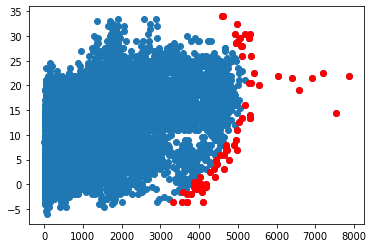

In [26]:
calculateOutliers('cnt', 't2')

#### cnt ~ hum

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


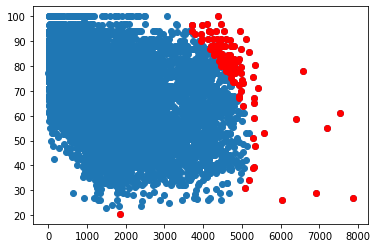

In [27]:
calculateOutliers('cnt', 'hum')

#### cnt ~ wind_speed

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


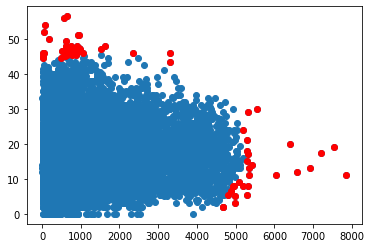

In [28]:
calculateOutliers('cnt', 'wind_speed')

# Klasteryzacja

TODO

Subplot, żeby pokazać obok siebie wszystkie metody (?)

## Metoda K-means

In [29]:
from sklearn.cluster import KMeans

def kmeans_clustering(col1, col2, clustersCount):
  dataset_cnt_t1 = dataset[[col1, col2]]

  # Default:
  # n_init = 10 - Number of time the k-means algorithm will be run with different centroid seeds
  # max_iter = 300 - Maximum number of iterations of the k-means algorithm for a single run.
  kmeans = KMeans(n_clusters=clustersCount).fit(dataset_cnt_t1)
  centers = kmeans.cluster_centers_
  print(centers)

  plt.scatter(dataset_cnt_t1[col1], dataset_cnt_t1[col2], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
  plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50)
  plt.show()

### cnt - t1

[[2245.72868463   15.30253566]
 [3965.8079242    16.47803618]
 [ 266.33522054   10.31441738]
 [1125.49136834   12.96944091]]


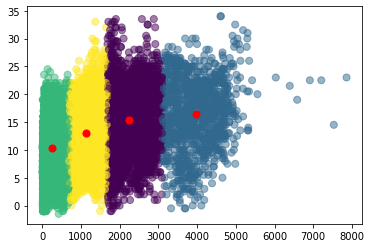

In [30]:
kmeans_clustering('cnt', 't1', 4)

### cnt - hum

[[ 268.86806283   80.14545157]
 [2247.3359822    63.9338843 ]
 [3965.8079242    61.99224806]
 [1129.94293031   68.41896836]]


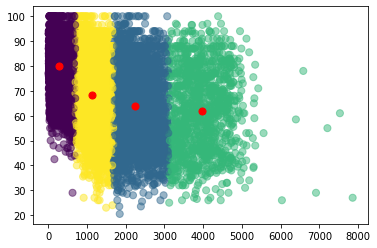

In [31]:
kmeans_clustering('cnt', 'hum', 4)

### cnt - wind_speed

[[ 266.33522054   14.41355058]
 [2245.19316023   16.81190627]
 [1125.18781818   17.26793939]
 [3965.8079242    16.85917313]]


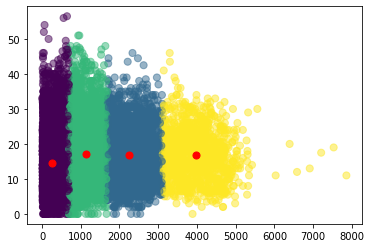

In [32]:
kmeans_clustering('cnt', 'wind_speed', 4)

### t1 - wind_speed - z ciekawości

[[ 8.68449128  8.12379651]
 [ 9.27061622 18.4218396 ]
 [18.30308494 14.24449119]
 [13.9842233  28.80071082]]


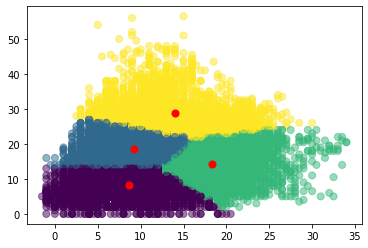

In [33]:
kmeans_clustering('t1', 'wind_speed', 4)

## Metoda hierarchiczna

### Dendrogram

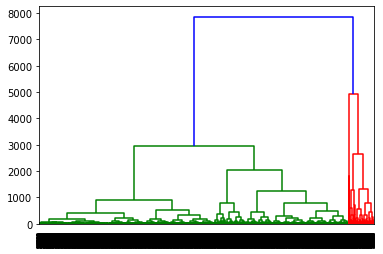

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage

# To trwa długo
Dendrogram = dendrogram((linkage(dataset[['cnt','t1']], method ='complete')))

In [47]:
from sklearn.cluster import AgglomerativeClustering

def agglomerative_clustering(col1, col2, clustersCount):
  aggClustering = AgglomerativeClustering(clustersCount)
  plt.scatter(dataset[col1], dataset[col2], 
             c = aggClustering.fit_predict(dataset[[col1, col2]]))
  plt.show()

### cnt - t1

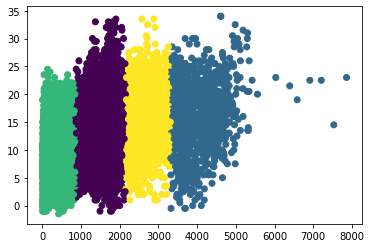

In [48]:
agglomerative_clustering('cnt', 't1', 4)

## Mean shift

In [84]:
from sklearn.cluster import MeanShift, estimate_bandwidth

def mean_shift_clustering(col1, col2, quantile):
  bandwidth = estimate_bandwidth(dataset[[col1, col2]], quantile=quantile)

  meanShift = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(dataset[[col1, col2]])
  labels = meanShift.labels_

  plt.scatter(dataset[col1], dataset[col2], c=labels)
  plt.show()

### cnt - t1

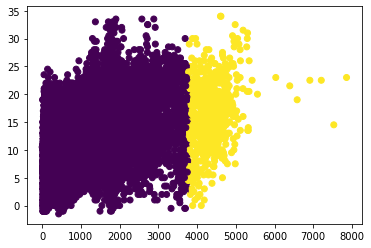

In [86]:
mean_shift_clustering('cnt', 't1', 0.5)